In [2]:
!pip install -U "transformers==4.53.3" datasets evaluate

In [3]:
from datasets import load_dataset

train_ds, val_ds = load_dataset("cifar100", split=["train[:90%]", "train[90%:]"]
)

test_ds = load_dataset("cifar100", split="test")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

cifar100/train-00000-of-00001.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

cifar100/test-00000-of-00001.parquet:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
train_ds

Dataset({
    features: ['img', 'fine_label', 'coarse_label'],
    num_rows: 45000
})

In [5]:
train_ds.features

{'img': Image(mode=None, decode=True),
 'fine_label': ClassLabel(names=['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 't

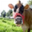

In [6]:
train_ds[0]['img']

In [7]:
id2label = {id:label for id, label in enumerate(train_ds.features["fine_label"].names)}
label2id = {label:id for id, label in id2label.items()}

In [8]:
id2label[train_ds[0]["fine_label"]]

'cattle'

In [9]:
from transformers import ViTImageProcessor
import numpy as np

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def preprocess_images(data):
    images = data["img"]
    inputs = processor(images=images, return_tensors="np")
    data["pixel_values"] = inputs["pixel_values"]

    data["labels"] = data["fine_label"]
    return data

columns_to_remove = ['img', 'fine_label', 'coarse_label']

train_ds = train_ds.map(preprocess_images, batched=True, remove_columns=columns_to_remove)
val_ds = val_ds.map(preprocess_images, batched=True, remove_columns=columns_to_remove)
test_ds = test_ds.map(preprocess_images, batched=True, remove_columns=columns_to_remove)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
from transformers import TFViTForImageClassification

model = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                    id2label=id2label,
                                                    label2id=label2id,
                                                    num_labels=len(id2label))

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should proba

In [11]:
model.summary()

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  76900     
                                                                 
Total params: 85875556 (327.59 MB)
Trainable params: 85875556 (327.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
steps_per_epoch = len(train_ds) // batch_size
total_train_steps = int(steps_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [13]:
from transformers import default_data_collator

train_dataset = model.prepare_tf_dataset(
    train_ds,
    shuffle=True,
    batch_size=32,
    collate_fn=default_data_collator,
)

test_dataset = model.prepare_tf_dataset(
    val_ds,
    shuffle=False,
    batch_size=32,
    collate_fn=default_data_collator,
)

In [14]:
model.compile(optimizer=optimizer)

In [15]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

In [16]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=test_dataset)

In [17]:
history = model.fit(x=train_dataset, validation_data=test_dataset, epochs=num_epochs, callbacks=[metric_callback])

Epoch 1/5
1406/1406 [==============================] - 2124s 1s/step - loss: 3.1238 - val_loss: 1.8472 - accuracy: 0.8718
Epoch 2/5
1406/1406 [==============================] - 2090s 1s/step - loss: 1.0764 - val_loss: 0.7431 - accuracy: 0.8976
Epoch 3/5
1406/1406 [==============================] - 2027s 1s/step - loss: 0.3884 - val_loss: 0.4883 - accuracy: 0.9030
Epoch 4/5
1406/1406 [==============================] - 2029s 1s/step - loss: 0.1843 - val_loss: 0.4197 - accuracy: 0.9042
Epoch 5/5
1406/1406 [==============================] - 2087s 1s/step - loss: 0.1032 - val_loss: 0.3982 - accuracy: 0.9054
